# 0号门年后数据分析 关门合并计算

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
#import pymysql
#pymysql.install_as_MySQLdb()
import MySQLdb as sql
import sklearn.mixture as mix
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns#添加Seaborn模块
%matplotlib inline
from pyecharts import Line

#不输出警告
import warnings
warnings.filterwarnings("ignore")
import time
import datetime
import pickle
from sklearn.externals import joblib
import os
filesave=os.getcwd()+r'\online_test'

## 高斯模型

In [2]:
#计算CV值
def calculate_cv(MG1,MG2):

    
    NumMixture1 = MG1.n_components
    NumMixture2 = MG2.n_components
    d = 0.0
    for k in range(0,NumMixture1):
        for j in range(0,NumMixture2):
            Sigma1 = MG1.covariances_[k]
            Mu1 = MG1.means_[k]
            Sigma2 = MG2.covariances_[j]
            Mu2 = MG2.means_[j]
            weight = MG1.weights_[k] * MG2.weights_[j]
            dist = L2Dist(Sigma1,Mu1,Sigma2,Mu2)
            d = d + weight*dist
    ''' the L2 norm of each GMM model'''
    n1 = 0.0
    n2 = 0.0
    for k in range(0,NumMixture1):
        for j in range(0,NumMixture1):
            Sigma1 = MG1.covariances_[k]
            Mu1 = MG1.means_[k]
            Sigma2 = MG1.covariances_[j]
            Mu2 = MG1.means_[j]
            weight = MG1.weights_[k]*MG1.weights_[j]
            n1 = n1 + weight * L2Dist(Sigma1,Mu1,Sigma2,Mu2)
    for k in range(0,NumMixture2):
        for j in range(0,NumMixture2):
            Sigma1 = MG2.covariances_[k]
            Mu1 = MG2.means_[k]
            Sigma2 = MG2.covariances_[j]
            Mu2 = MG2.means_[j]
            weight = MG2.weights_[k]*MG2.weights_[j]
            n2 = n2 + weight * L2Dist(Sigma1,Mu1,Sigma2,Mu2)
    cv = d/np.sqrt(n1)/np.sqrt(n2)
    return cv

In [3]:
#计算两个高斯分布之间的距离
def L2Dist(sigma1,mean1,sigma2,mean2):
    '''
    calculate the L2 distance between two multivariate Gaussian distributisons
    
    '''    
    n = mean1.size
    
    '''L2 norm of sigma1, mean1'''
    
    invsigma1 = np.linalg.inv(sigma1)
    invsigma2 = np.linalg.inv(sigma2)
    u = invsigma1*mean1 + invsigma2*mean2
    invsigma = np.linalg.inv(sigma1+sigma2)
    f1norm = 1/math.sqrt( math.sqrt( (2*math.pi)**n*np.linalg.det(sigma1)*2**n ) )
    '''L2 norm of sigma2, mean2'''
    f2norm = 1/math.sqrt( math.sqrt( (2*math.pi)**n*np.linalg.det(sigma2)*2**n ) )
    '''inner product of pdf f1 and f2'''
    
    InnerProd = 1/(math.sqrt(2*math.pi)**n) * math.sqrt(np.linalg.det(invsigma)) * \
                np.exp(-1/2*(-u.T*sigma1*invsigma*sigma2*u + mean1.T*invsigma1*mean1 + mean2.T*invsigma2*mean2))
    '''L2 distance between f1 and f2'''
    d = InnerProd/f1norm/f2norm
    
    return d

In [4]:
#训练高斯模型
def gmm_clustering(k,X,cov_type=None):
    '''
    基于高斯混合模型GMM进行无监督学习，聚类
    其中GMM采用传统的EM算法进行参数估计
    
    输入参数含义:
    k    ————   聚类的数目，必填项
    X    ————   样本的输入，比填项
    cov_type  ————  协方差类型，可选项
            四种选择：'spherical', 'tied', 'diag', 'full'
            如果不填写，则默认为'full'
        
    '''
    if cov_type is None:
        cov_type = 'full'   
    
    gmm = mix.GaussianMixture(n_components=k,covariance_type=cov_type)
    gmm.fit(X)
    
    return gmm

### 导入数据

In [5]:
# #连接本地数据库
# config={'user': 'root',
#         'passwd': 'ABCabc123',
#         'host': '127.0.0.1',
#         'db': 'maoqing'}
#连接外部数据库
config = {'user': 'root',
             'passwd': 'ABCabc123',
             'host': '10.84.1.20',
             'db': 'maoqing'}
database='door_data_can0812'
sql_statement="select * from "+database+" where HAPPENTIME > '2019-02-13' and GATE = 0"#  read_flag is nulland  

#while(1):
#链接数据库读取新数据
conn = sql.connect(**config)
cur = conn.cursor(cursorclass=sql.cursors.DictCursor)#返回字段名
#根据read_flag为null筛选出新录入的数据
#cur.execute("select * from "+database+" where read_flag is null")#door_data_can 为原始数据表名
#data=cur.fetchall()#执行读取操作
#rawdata_can = pd.DataFrame(list(data))#将读取结果转为dataframe格式
rawdata_can=pd.read_sql(sql_statement,conn)
rawdata_can.head()
#将HAPPENTIME列属性改为时间，并设置为index        
rawdata_can['HAPPENTIME']=pd.to_datetime(rawdata_can['HAPPENTIME'])
rawdata_can=rawdata_can.set_index('HAPPENTIME')
# rawdata_can=rawdata_can.set_index('id')
rawdata_can.shape
rawdata_can.head()

,id,MJYXSJID,UPLOADTIME,RECEIVETIME,SAVETIME,VERSION_UP,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,ID_SUM_N,DOOR_STATE_Z,EM,BACKUP1,BACKUP2,CV,read_flag,alarm_level,actual_result,predicte_result
HAPPENTIME,,,,,,,,,,,,,,,,,,,,,
2019-02-14 09:50:14,716898,MJYXSJID-400251,2019-02-14 09:50:14,2019-02-14 09:50:14,2019-02-14 09:50:14,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,0,0010111000000010,0,BAK1,Bak2,NaN,1.0,NaN,None,None
2019-02-14 09:51:04,716903,MJYXSJID-400256,2019-02-14 09:51:04,2019-02-14 09:51:04,2019-02-14 09:51:04,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,6157,0000001000101110,-1,BAK1,Bak2,NaN,1.0,NaN,None,None
2019-02-14 09:51:14,716904,MJYXSJID-400257,2019-02-14 09:51:14,2019-02-14 09:51:14,2019-02-14 09:51:14,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,0,0010111000000010,0,BAK1,Bak2,NaN,1.0,NaN,None,None
2019-02-14 09:52:04,716907,MJYXSJID-400260,2019-02-14 09:52:04,2019-02-14 09:52:04,2019-02-14 09:52:04,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,6341,0000001000101110,-1,BAK1,Bak2,NaN,1.0,NaN,None,None
2019-02-14 09:52:14,716908,MJYXSJID-400261,2019-02-14 09:52:14,2019-02-14 09:52:14,2019-02-14 09:52:14,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,0,0010111000000010,0,BAK1,Bak2,NaN,1.0,NaN,None,None


In [6]:
#筛选开门数据
rawdata_can_open1=rawdata_can[(rawdata_can['DOOR_STATE'].astype(str)=='0010011100100101')&(rawdata_can['GATE'].astype(str)==str(0))].loc[:'2019-04-01',:]
rawdata_can_open2=rawdata_can[(rawdata_can['DOOR_STATE'].astype(str)=='0010011100100101')&(rawdata_can['GATE'].astype(str)==str(0))&(rawdata_can['DOOR_STATE_Z'].astype(str)=='0010011000100111')].loc['2019-04-01':,:]
rawdata_can_open=rawdata_can_open1.append(rawdata_can_open2)
rawdata_can_open=rawdata_can_open.loc[:,['E_Q', 'E_D', 'SPEED_SUM',  'SPEED_MAX_P',
   'SPEED_MAX_N', 'SPEED_MAX_N_POSITION', 'START_POSITION', 'END_POSITION',
   'IQ_SUM_P', 'IQ_SUM_N', 'ID_SUM_P', 'ID_SUM_N', 'EM','SPEED_SUM_SQR','SPEED_SUM_CNT']].copy()
rawdata_can_open=rawdata_can_open.dropna()#删除缺失数据
rawdata_can_open['SPEED_SUM_SQR_REAL'] = rawdata_can_open['SPEED_SUM_SQR']/rawdata_can_open['SPEED_SUM_CNT']
rawdata_can_open=rawdata_can_open.drop(labels=['SPEED_SUM_SQR','SPEED_SUM_CNT'],axis=1)#删除计算后的两列
rawdata_can_open.head()


,E_Q,E_D,SPEED_SUM,SPEED_MAX_P,SPEED_MAX_N,SPEED_MAX_N_POSITION,START_POSITION,END_POSITION,IQ_SUM_P,IQ_SUM_N,ID_SUM_P,ID_SUM_N,EM,SPEED_SUM_SQR_REAL
HAPPENTIME,,,,,,,,,,,,,,
2019-02-14 09:53:14,183,-1,3054,114,-126,32473,35245,16582,17,5281737,76665,81934,113,2489.706667
2019-02-14 10:01:26,181,-1,2970,134,-130,34938,35260,16582,137,5196396,78432,83412,112,2336.360743
2019-02-14 10:02:26,178,-1,2850,144,-122,35038,35257,16582,186,5053643,71356,76308,110,2178.164456
2019-02-14 10:03:26,180,-1,2774,134,-122,35039,35238,16582,44,5129851,75963,84820,111,2519.040000
2019-02-14 10:04:26,178,-1,2814,135,-122,35039,35238,16582,65,5069972,75453,80255,111,2322.453333


In [7]:
#筛选关门数据和关门不到位数据
rawdata_can_close=rawdata_can[((rawdata_can['DOOR_STATE'].astype(str)=='0010101100101010')^(rawdata_can['DOOR_STATE'].astype(str)=='0010101100100011'))&(rawdata_can['GATE'].astype(str)==str(0))] #
rawdata_can_close.groupby('DOOR_STATE').count()

,id,MJYXSJID,UPLOADTIME,RECEIVETIME,SAVETIME,VERSION_UP,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,ID_SUM_N,DOOR_STATE_Z,EM,BACKUP1,BACKUP2,CV,read_flag,alarm_level,actual_result,predicte_result
DOOR_STATE,,,,,,,,,,,,,,,,,,,,,
0010101100100011,4576,4576,4576,4576,4576,4576,4576,4576,4576,4576,...,4576,4576,4576,4576,4576,4529,4576,4434,4446,4434
0010101100101010,248379,248379,248379,248379,248379,248379,248379,248379,248379,248379,...,248379,248379,248379,248379,248379,248365,248374,207098,207098,207098


In [8]:
rawdata_can_close=rawdata_can_close.loc[:,['E_Q', 'E_D', 'SPEED_SUM',  'SPEED_MAX_P',
   'SPEED_MAX_N', 'SPEED_MAX_N_POSITION', 'START_POSITION', 'END_POSITION',
   'IQ_SUM_P', 'IQ_SUM_N', 'ID_SUM_P', 'ID_SUM_N', 'EM','SPEED_SUM_SQR','SPEED_SUM_CNT']].copy()
rawdata_can_close=rawdata_can_close.dropna()#删除缺失数据
rawdata_can_close['SPEED_SUM_SQR_REAL'] = rawdata_can_close['SPEED_SUM_SQR']/rawdata_can_close['SPEED_SUM_CNT']
rawdata_can_close=rawdata_can_close.drop(labels=['SPEED_SUM_SQR','SPEED_SUM_CNT'],axis=1)#删除计算后的两列
rawdata_can_close.head()

,E_Q,E_D,SPEED_SUM,SPEED_MAX_P,SPEED_MAX_N,SPEED_MAX_N_POSITION,START_POSITION,END_POSITION,IQ_SUM_P,IQ_SUM_N,ID_SUM_P,ID_SUM_N,EM,SPEED_SUM_SQR_REAL
HAPPENTIME,,,,,,,,,,,,,,
2019-02-14 09:53:49,200,-2,-2550,68,-93,29262,17054,30099,4864314,221341,148233,110696,75,508.515376
2019-02-14 10:02:14,199,-2,-2656,87,-93,29277,17050,30084,4776604,207133,143495,109576,75,579.037116
2019-02-14 10:02:46,197,-2,-2516,87,-73,28700,17051,30082,4720087,199981,149572,111782,74,534.413574
2019-02-14 10:03:46,199,-2,-2216,107,-93,29267,17051,30075,4795994,196879,146906,111061,75,582.006363
2019-02-14 10:04:46,198,-2,-2456,87,-93,29271,17051,30081,4767454,202164,147116,110522,75,570.595970


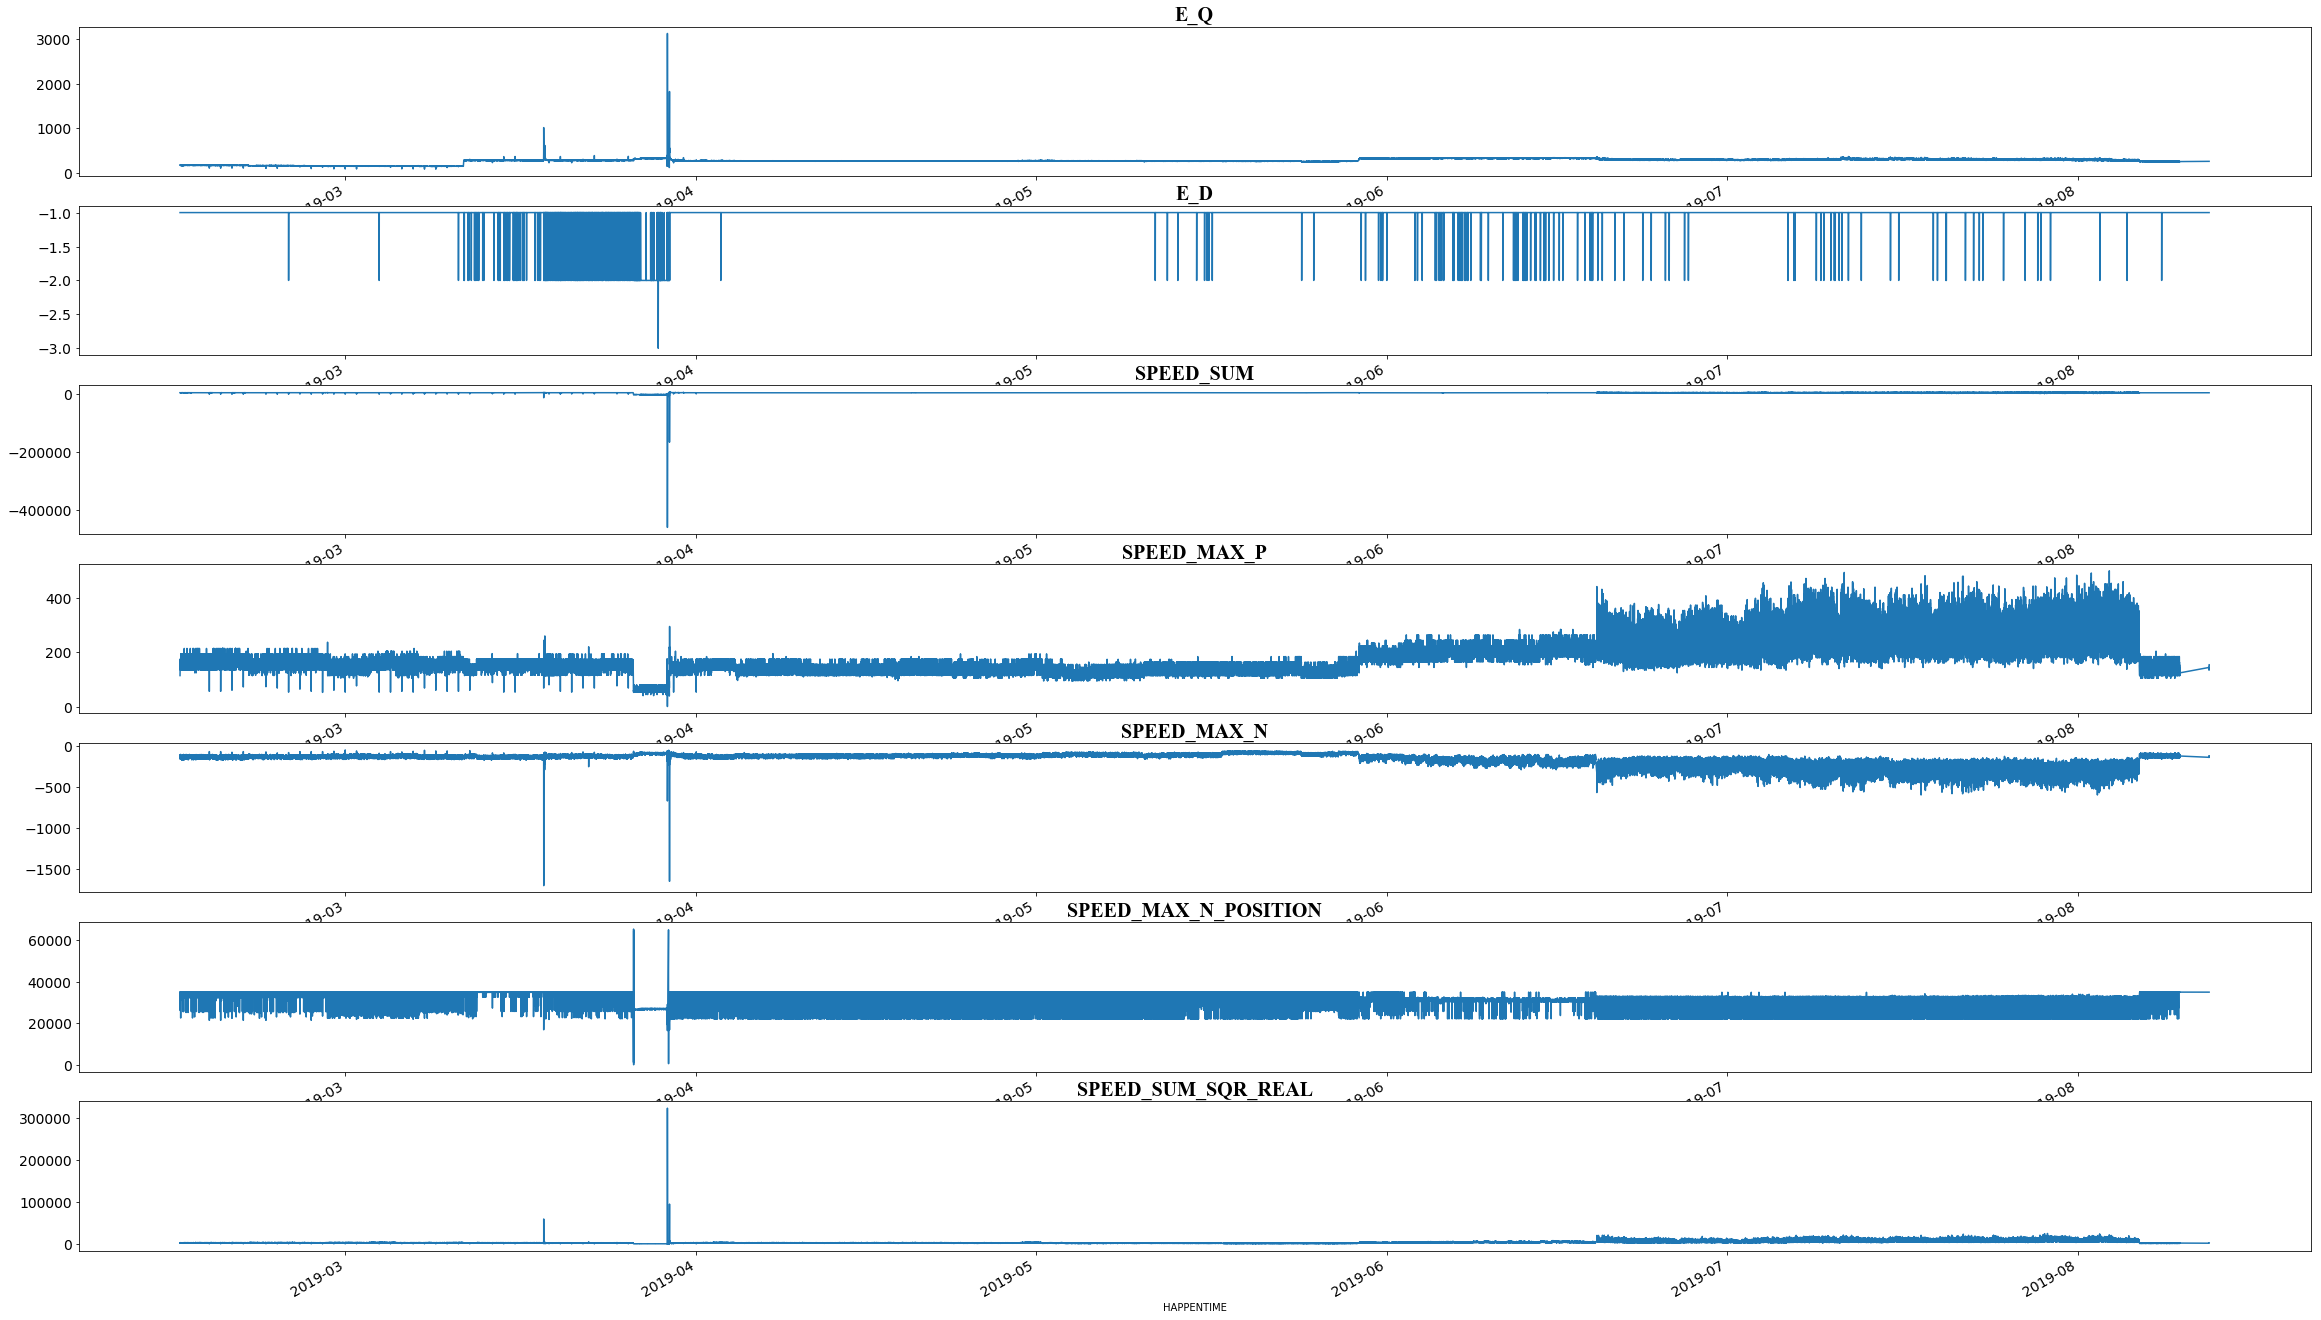

In [9]:
#开门原始数据可视化
rawdata_can_open1=rawdata_can_open.copy()
font= {'family': 'Times New Roman',
         'weight': 'bold',
         'size':20,
         }
plt.figure(figsize=(40,25))
clounmlist=['E_Q', 'E_D', 'SPEED_SUM', 'SPEED_MAX_P',
            'SPEED_MAX_N', 'SPEED_MAX_N_POSITION', 'START_POSITION', 'END_POSITION',
            'IQ_SUM_P', 'IQ_SUM_N', 'ID_SUM_P', 'ID_SUM_N', 'EM',
            'SPEED_SUM_SQR_REAL']

plt.subplot(711)
rawdata_can_open1['E_Q'].plot()
plt.title('E_Q',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(712)
rawdata_can_open1['E_D'].plot()
plt.title('E_D',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(713)
rawdata_can_open1['SPEED_SUM'].plot()
plt.title('SPEED_SUM',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(714)
rawdata_can_open1['SPEED_MAX_P'].plot()
plt.title('SPEED_MAX_P',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(715)
rawdata_can_open1['SPEED_MAX_N'].plot()
plt.title('SPEED_MAX_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(716)
rawdata_can_open1['SPEED_MAX_N_POSITION'].plot()
plt.title('SPEED_MAX_N_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(717)
rawdata_can_open1['SPEED_SUM_SQR_REAL'].plot()
plt.title('SPEED_SUM_SQR_REAL',fontdict=font)
plt.tick_params(labelsize=14)

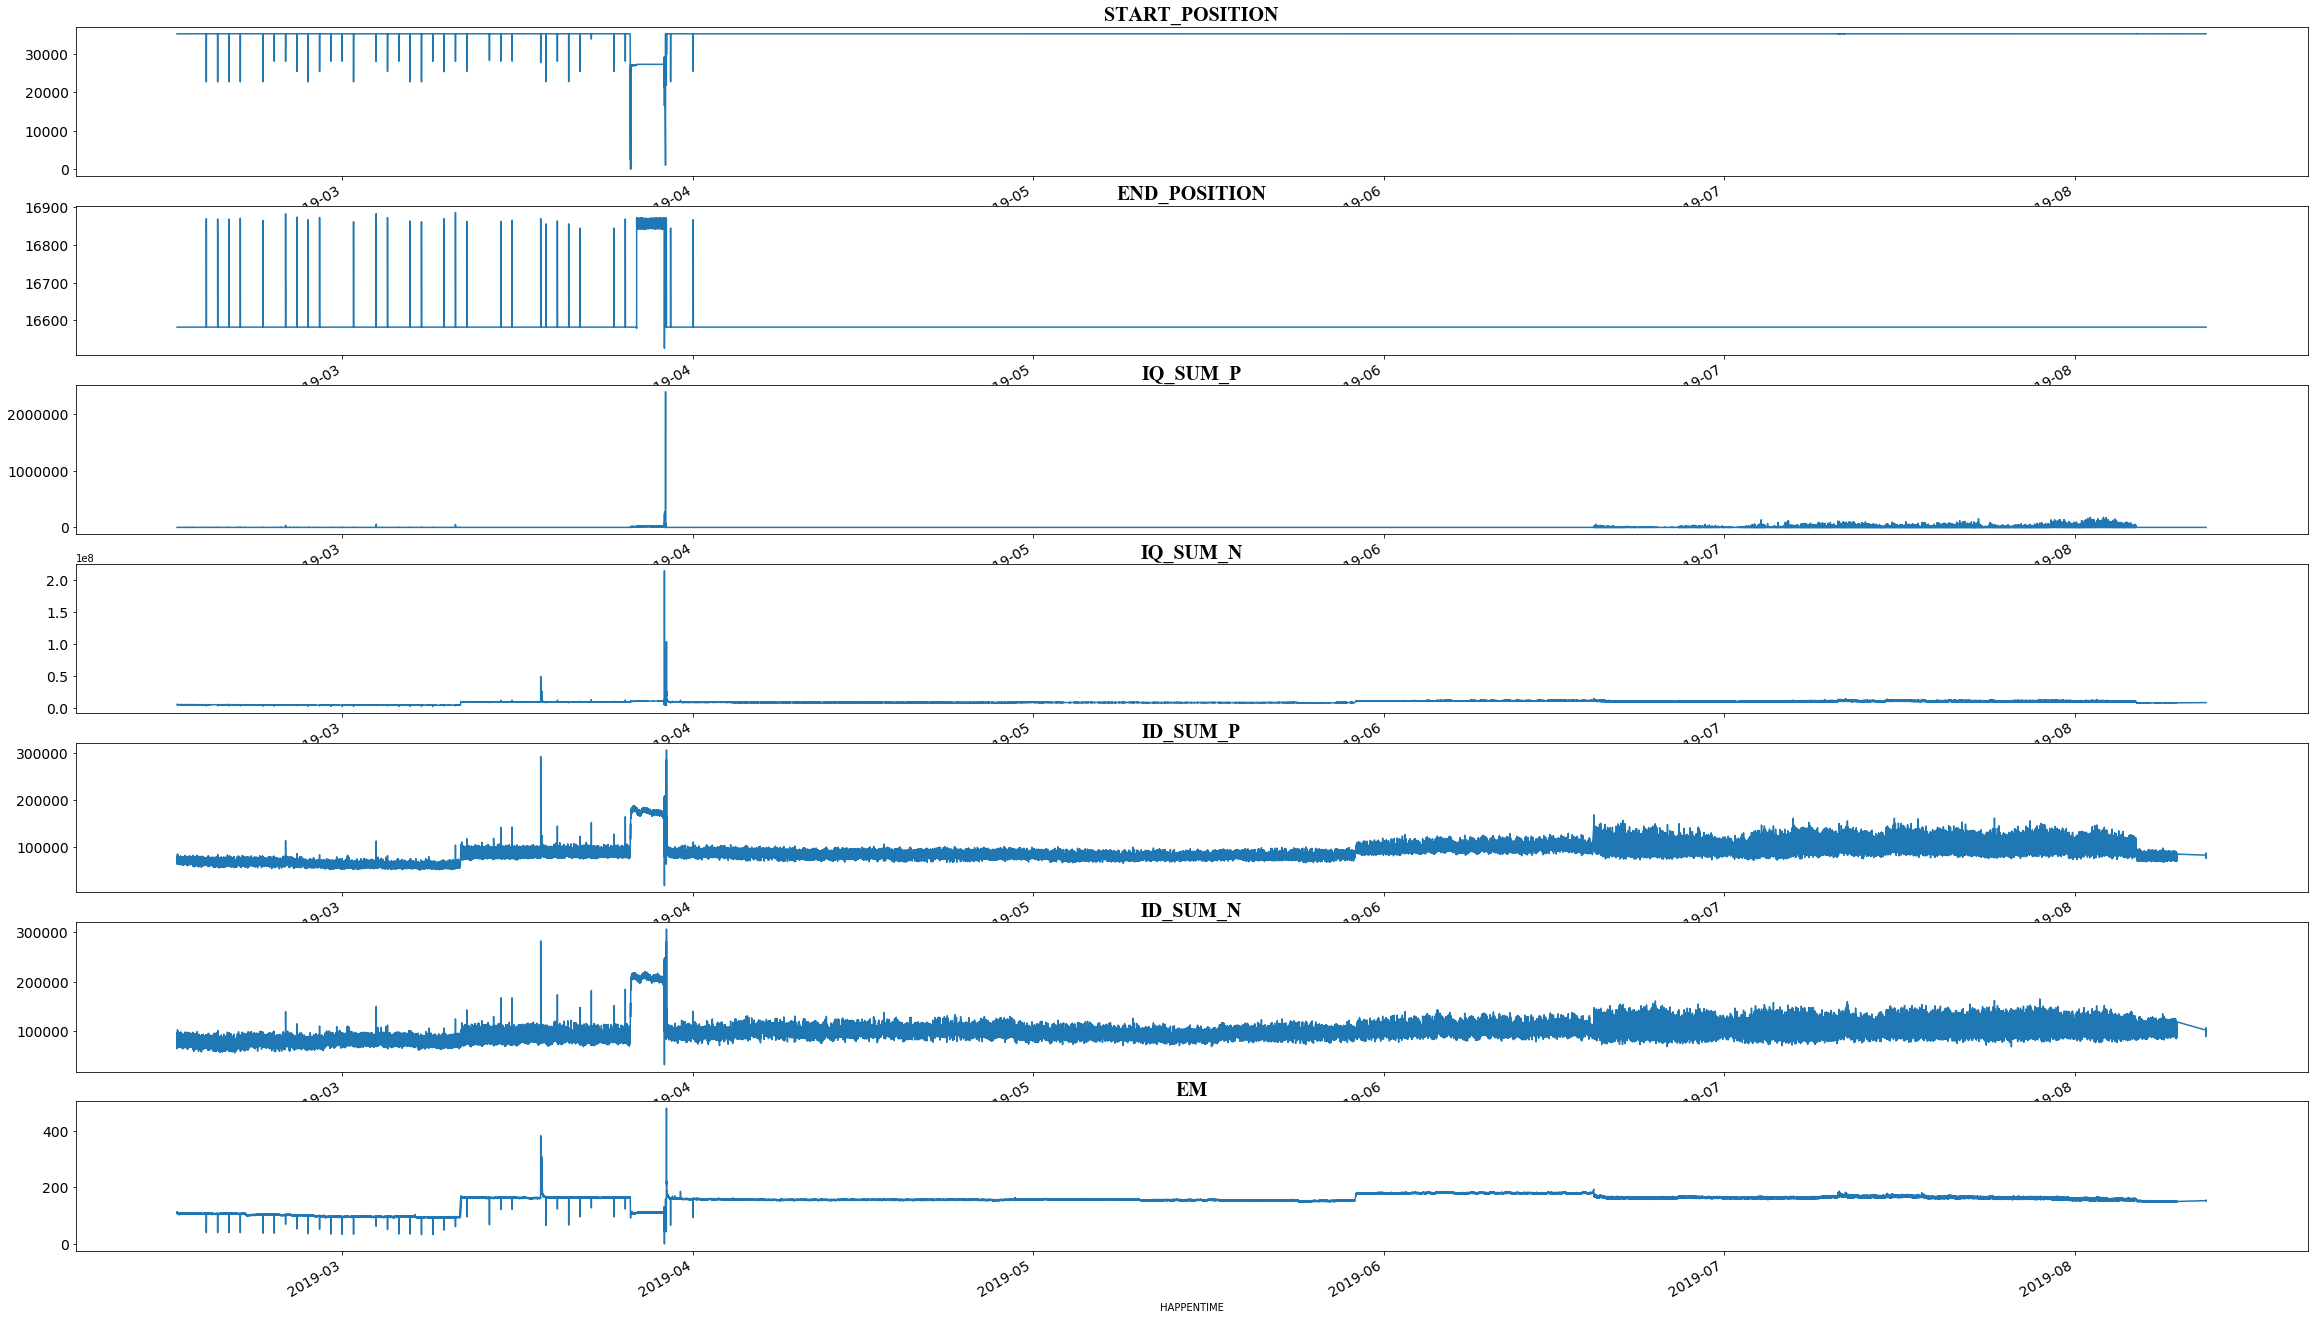

In [10]:
#开门原始数据可视化
font= {'family': 'Times New Roman',
         'weight': 'bold',
         'size':20,
         }
plt.figure(figsize=(40,25))
plt.subplot(711)
rawdata_can_open1['START_POSITION'].plot()
plt.title('START_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(712)
rawdata_can_open1['END_POSITION'].plot()
plt.title('END_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(713)
rawdata_can_open1['IQ_SUM_P'].plot()
plt.title('IQ_SUM_P',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(714)
rawdata_can_open1['IQ_SUM_N'].plot()
plt.title('IQ_SUM_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(715)
rawdata_can_open1['ID_SUM_P'].plot()
plt.title('ID_SUM_P',fontdict=font)
plt.tick_params(labelsize=14)

plt.subplot(716)
rawdata_can_open1['ID_SUM_N'].plot()
plt.title('ID_SUM_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(717)
rawdata_can_open1['EM'].plot()
plt.title('EM',fontdict=font)
plt.tick_params(labelsize=14)


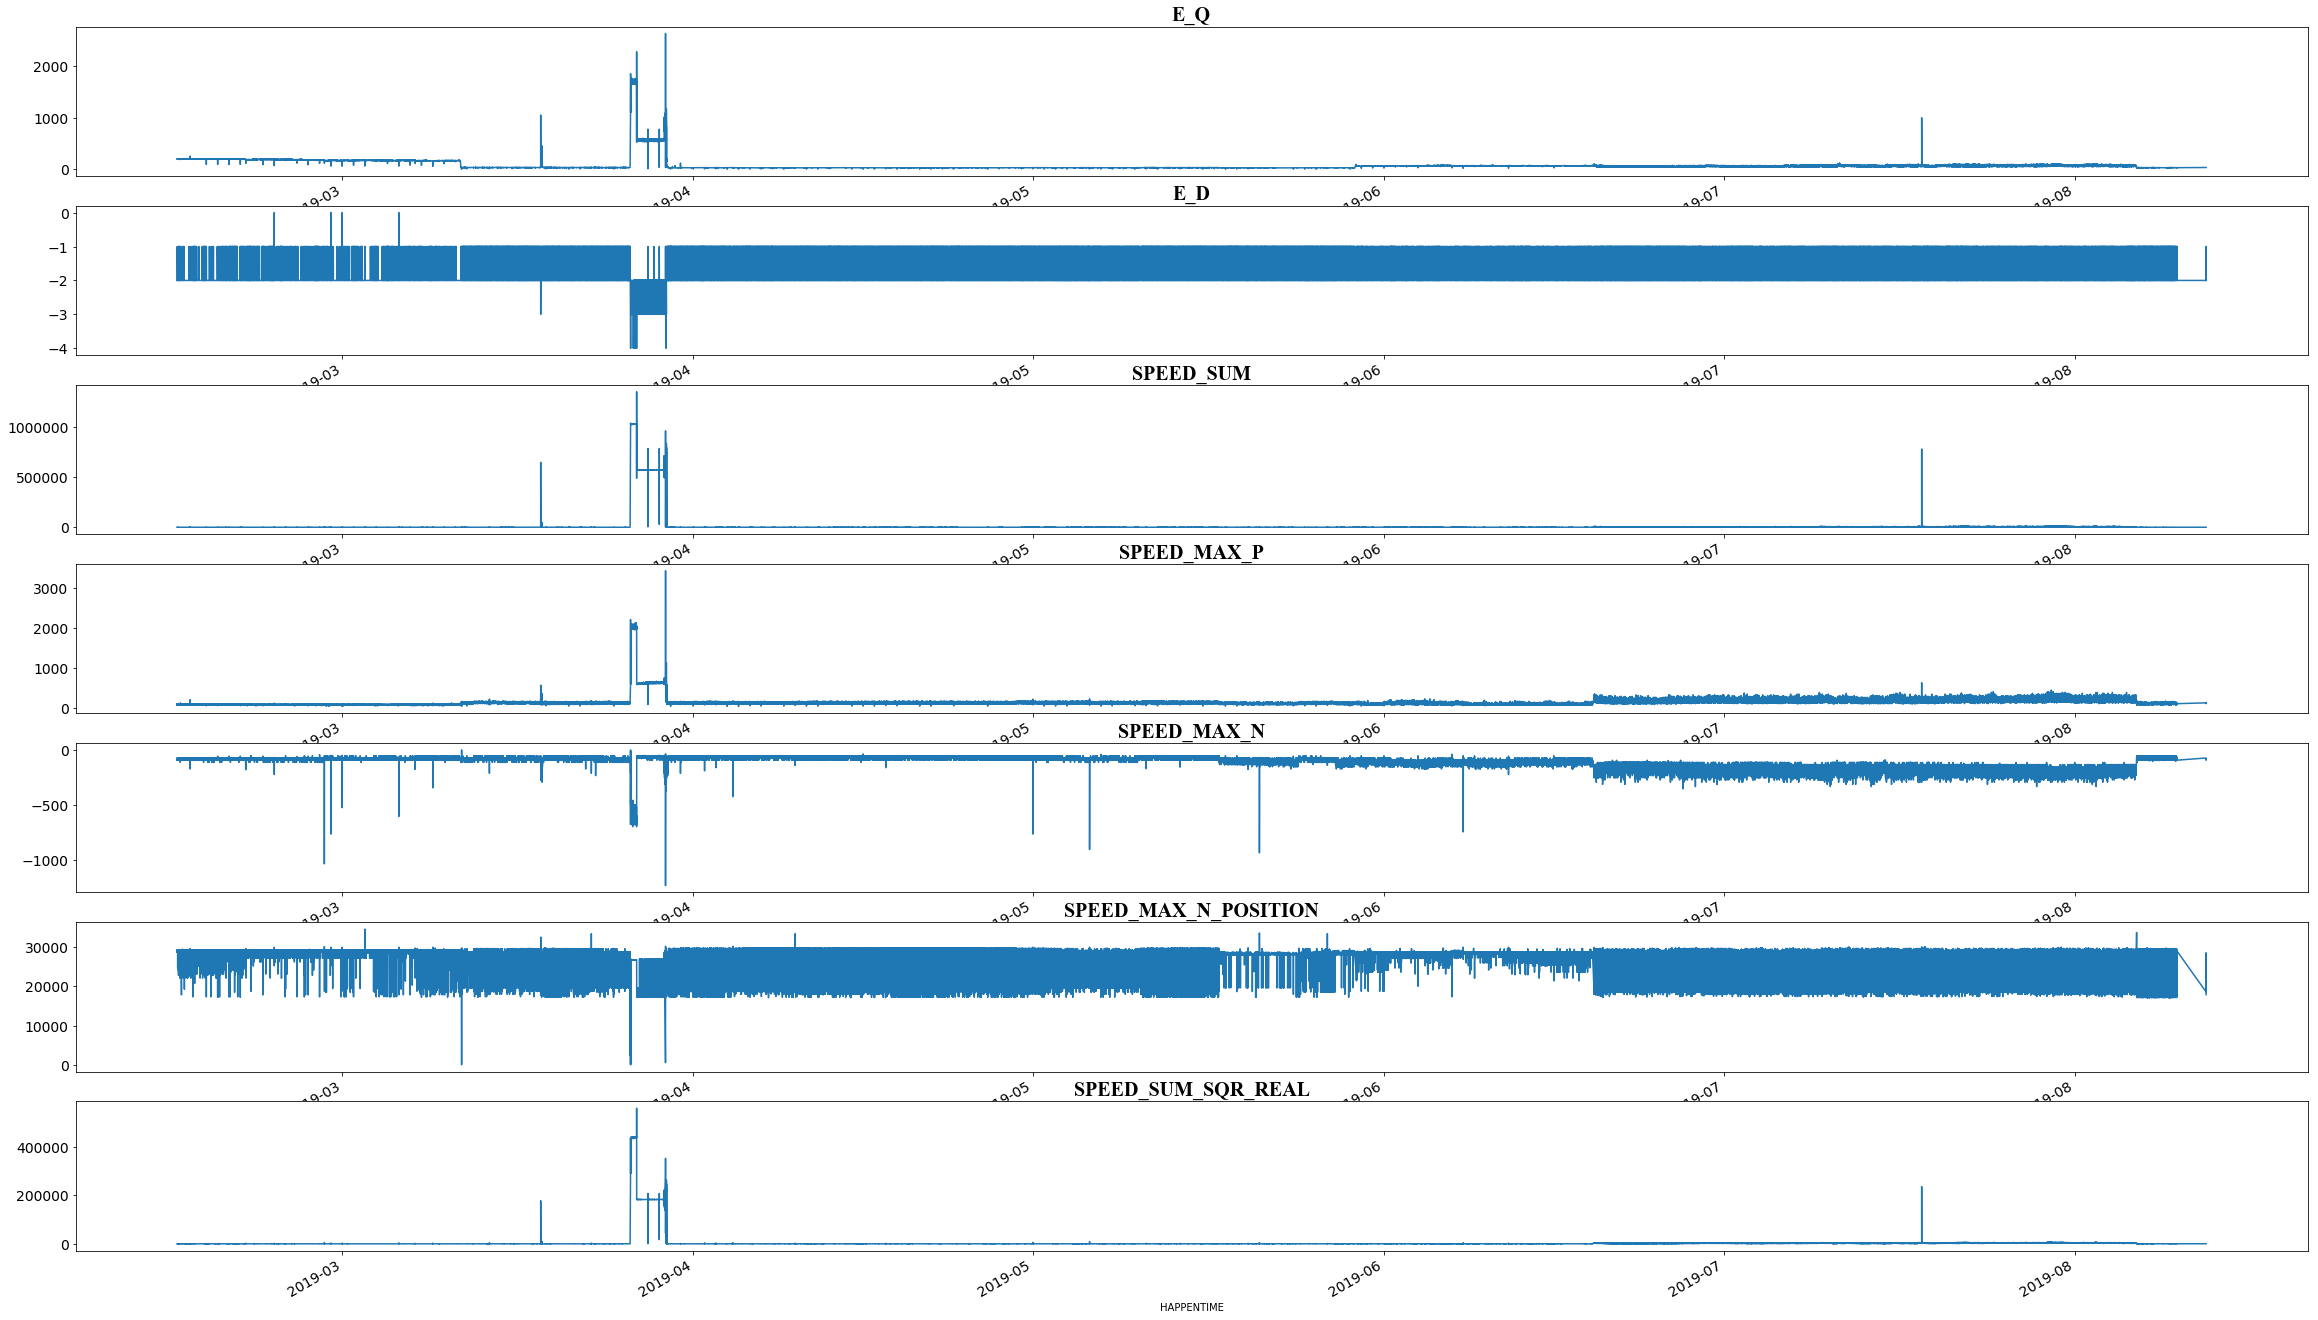

In [11]:
#关门原始数据可视化
rawdata_can_open1=rawdata_can_close.copy()
font= {'family': 'Times New Roman',
         'weight': 'bold',
         'size':20,
         }
plt.figure(figsize=(40,25))
clounmlist=['E_Q', 'E_D', 'SPEED_SUM', 'SPEED_SUM_CNT', 'SPEED_MAX_P',
            'SPEED_MAX_N', 'SPEED_MAX_N_POSITION', 'START_POSITION', 'END_POSITION',
            'IQ_SUM_P', 'IQ_SUM_N', 'ID_SUM_P', 'ID_SUM_N', 'EM',
            'SPEED_SUM_SQR_REAL']

plt.subplot(711)
rawdata_can_open1['E_Q'].plot()
plt.title('E_Q',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(712)
rawdata_can_open1['E_D'].plot()
plt.title('E_D',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(713)
rawdata_can_open1['SPEED_SUM'].plot()
plt.title('SPEED_SUM',fontdict=font)
plt.tick_params(labelsize=14)

plt.subplot(714)
rawdata_can_open1['SPEED_MAX_P'].plot()
plt.title('SPEED_MAX_P',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(715)
rawdata_can_open1['SPEED_MAX_N'].plot()
plt.title('SPEED_MAX_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(716)
rawdata_can_open1['SPEED_MAX_N_POSITION'].plot()
plt.title('SPEED_MAX_N_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(717)
rawdata_can_open1['SPEED_SUM_SQR_REAL'].plot()
plt.title('SPEED_SUM_SQR_REAL',fontdict=font)
plt.tick_params(labelsize=14)

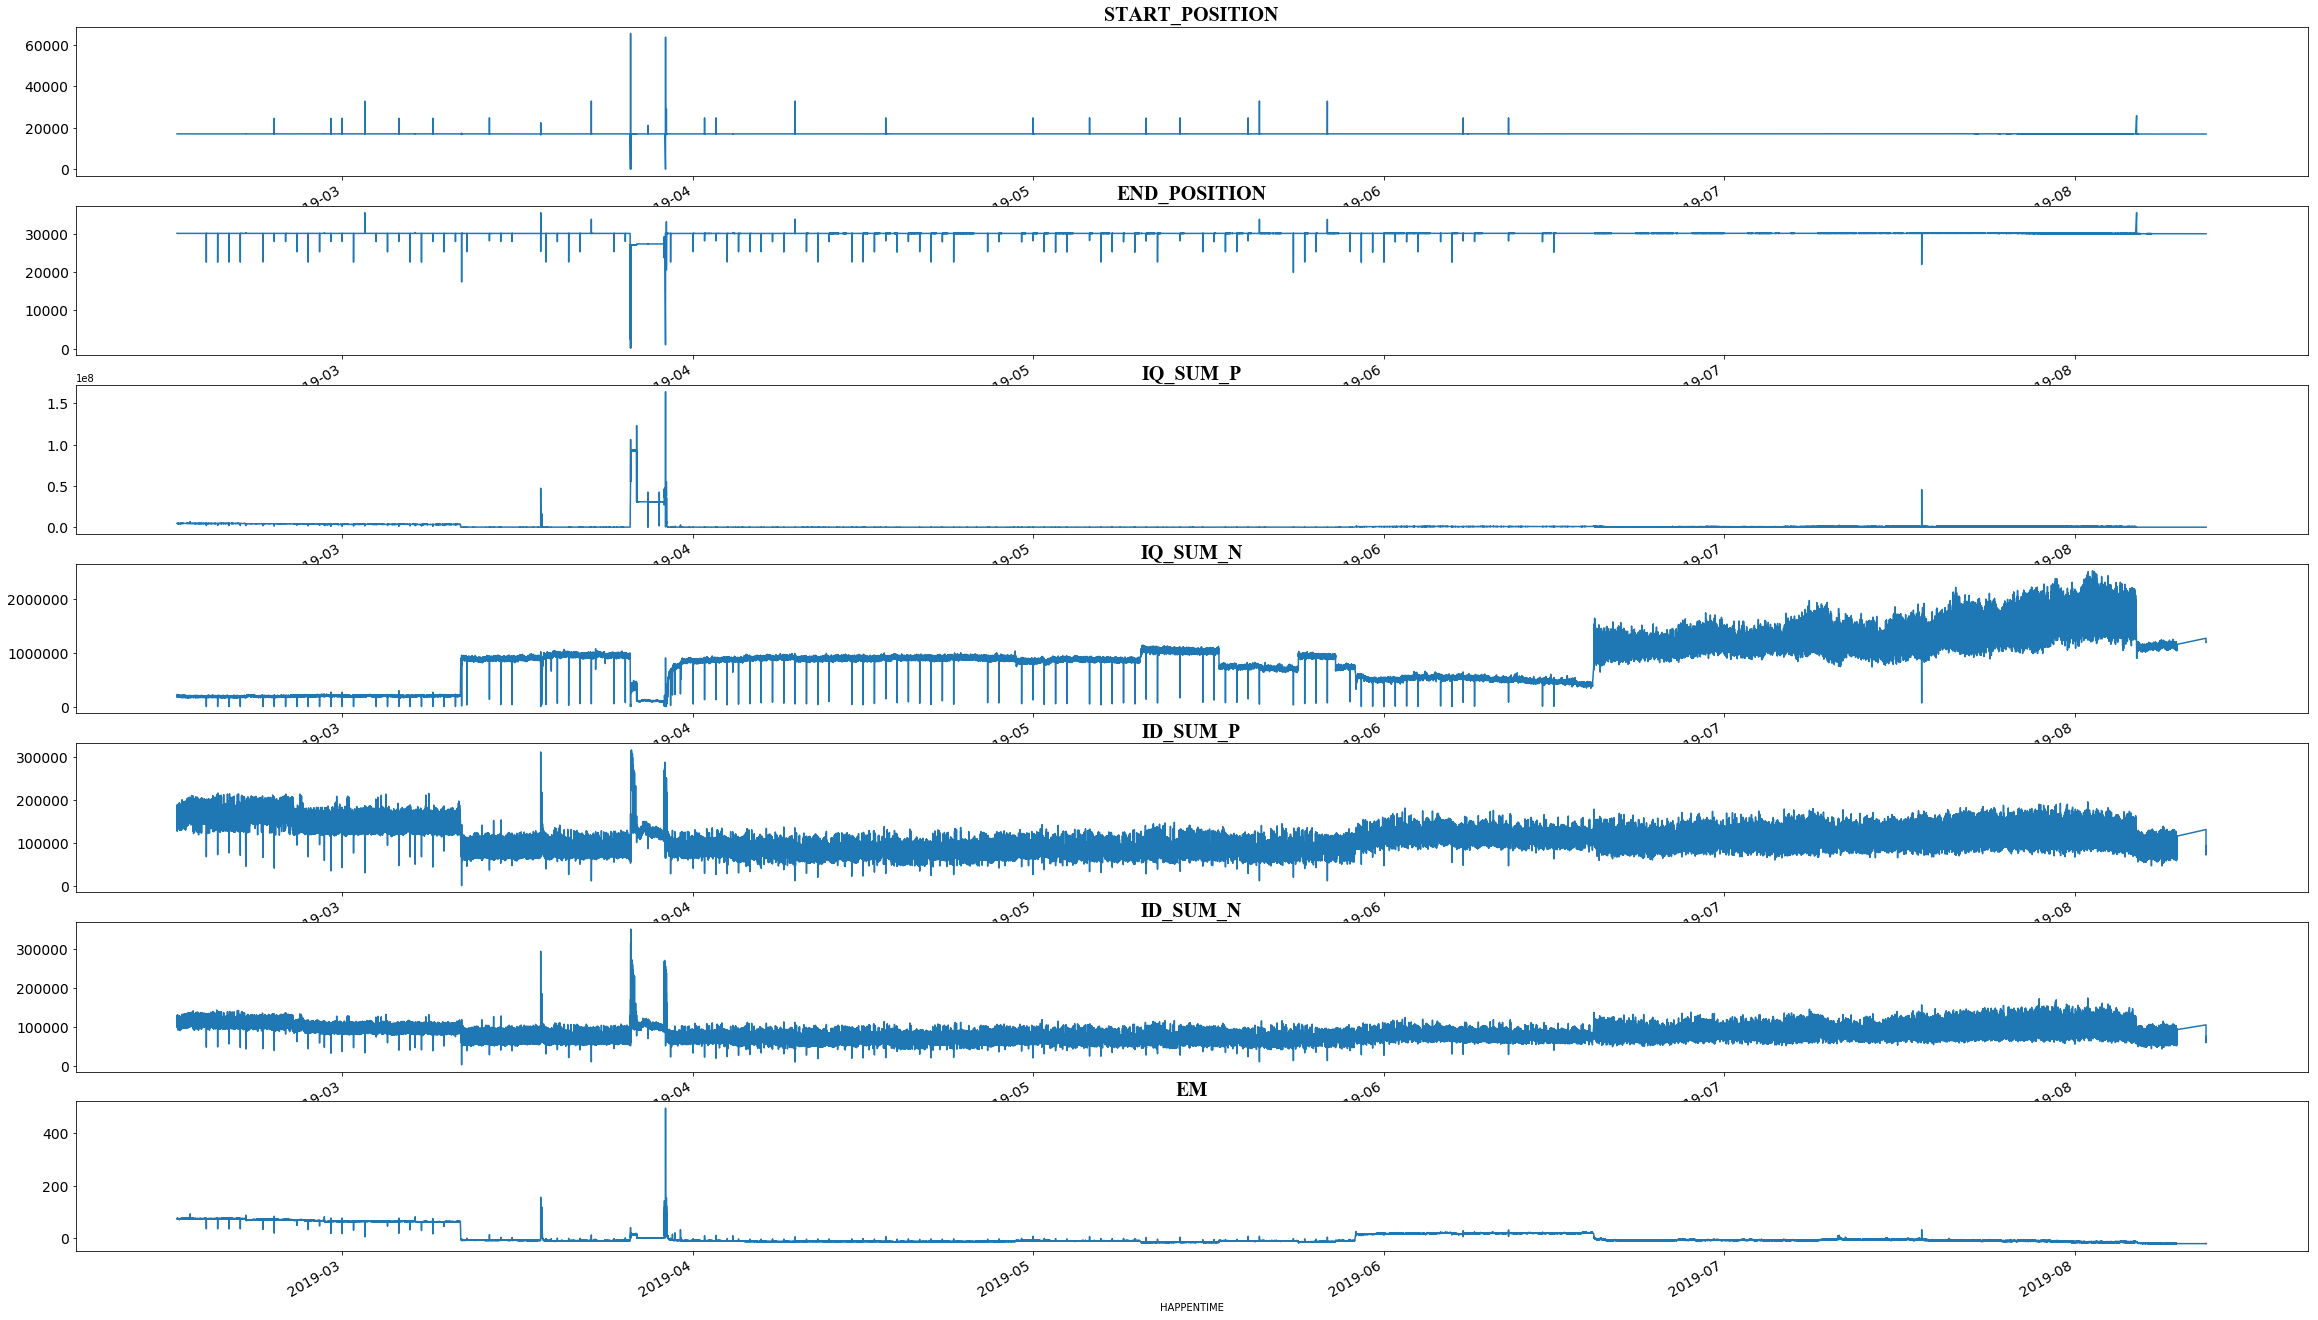

In [12]:
#关门原始数据可视化
font= {'family': 'Times New Roman',
         'weight': 'bold',
         'size':20,
         }
plt.figure(figsize=(40,25))
plt.subplot(711)
rawdata_can_open1['START_POSITION'].plot()
plt.title('START_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(712)
rawdata_can_open1['END_POSITION'].plot()
plt.title('END_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(713)
rawdata_can_open1['IQ_SUM_P'].plot()
plt.title('IQ_SUM_P',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(714)
rawdata_can_open1['IQ_SUM_N'].plot()
plt.title('IQ_SUM_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(715)
rawdata_can_open1['ID_SUM_P'].plot()
plt.title('ID_SUM_P',fontdict=font)
plt.tick_params(labelsize=14)

plt.subplot(716)
rawdata_can_open1['ID_SUM_N'].plot()
plt.title('ID_SUM_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(717)
rawdata_can_open1['EM'].plot()
plt.title('EM',fontdict=font)
plt.tick_params(labelsize=14)


In [14]:
#对所有的特征做归一化处理 
from sklearn import preprocessing
#原始数据
data_st1_nors = rawdata_can_open.copy()
data_st2_nors = rawdata_can_close.copy()
#data_st1_nors = rawdata_can_open.iloc[1000:][:].copy()
#data_st2_nors = rawdata_can_close.iloc[1000:][:].copy()



#load标准化模型
standardscaler_st1 = joblib.load(filesave+r'\onlycan_opendata_sd_model0.pkl') 

standardscaler_st2 = joblib.load(filesave+r'\onlycan_closedata_sd_model0.pkl') 


#使用该模型将未去除离群点的数据归一化
data_st1_sd = standardscaler_st1.transform(data_st1_nors)
data_st1_sd = pd.DataFrame(data_st1_sd)
#data_st1_sd['HAPPENTIME']=data_st1_nors.index
#data_st1_sd=data_st1_sd.set_index('HAPPENTIME')
data_st1_sd.index=data_st1_nors.index
data_st1_sd.columns=data_st1_nors.columns

data_st2_sd = standardscaler_st2.transform(data_st2_nors)
data_st2_sd = pd.DataFrame(data_st2_sd)
#data_st2_sd['HAPPENTIME']=data_st2_nors.index
#data_st2_sd=data_st2_sd.set_index('HAPPENTIME')
data_st2_sd.index=data_st2_nors.index
data_st2_sd.columns=data_st2_nors.columns

print(data_st1_sd.mean(axis=0))#应该都是0
print(data_st1_sd.std(axis=0))#应该都是1



FileNotFoundError: [Errno 2] No such file or directory: '\\online_test\\onlycan_opendata_sd_model0.pkl'

In [ ]:
def count_gmm(x):
    if x > 0.5:
        return 1
    else:
        return 0

### 开门数据

In [ ]:
#建立高斯混合模型---开门状态
if __name__ == '__main__':
    k = 1
    cv1 = np.zeros(1)
    #data_so = data_st1_sd.copy()
    data_s = data_st1_sd.copy()
    
    normal_obj = joblib.load(filesave+'\onlycan_opendata_normal_obj_model0.pkl') 
    a = len(data_s)
    cv = np.zeros(a)

    
    #使用高斯混合模型进行计算
    def gmm_apply(x,k,normal_obj):
        data_l = pd.DataFrame(x)
        test_obj = gmm_clustering(k,data_l)#test_obj为训练好的gmm模型，需保存
        y = calculate_cv(normal_obj,test_obj)#y为[[cv值]]，只返回cv值
        return y[0][0]
    
    #计算每一行的cv值，存在data_s的cv列中         
    data_s['cv']=data_s.apply(lambda row:gmm_apply(row,k,normal_obj), axis=1)
    
    #计算cv的均值
    #cv1= data_s['cv']#cv1为Series
    #print(type(cv1))
    c = data_s['cv'].mean()
    #计算cv值小于设定阈值的个数
    count =0    
    data_s['health_label']=data_s['cv'].map(count_gmm) 
    count=data_s['health_label'].sum()   
    
    
    print(a)
    print(count)    
    print(c)
   # print(cv1.head())

    data_s_open=data_s.copy()
    


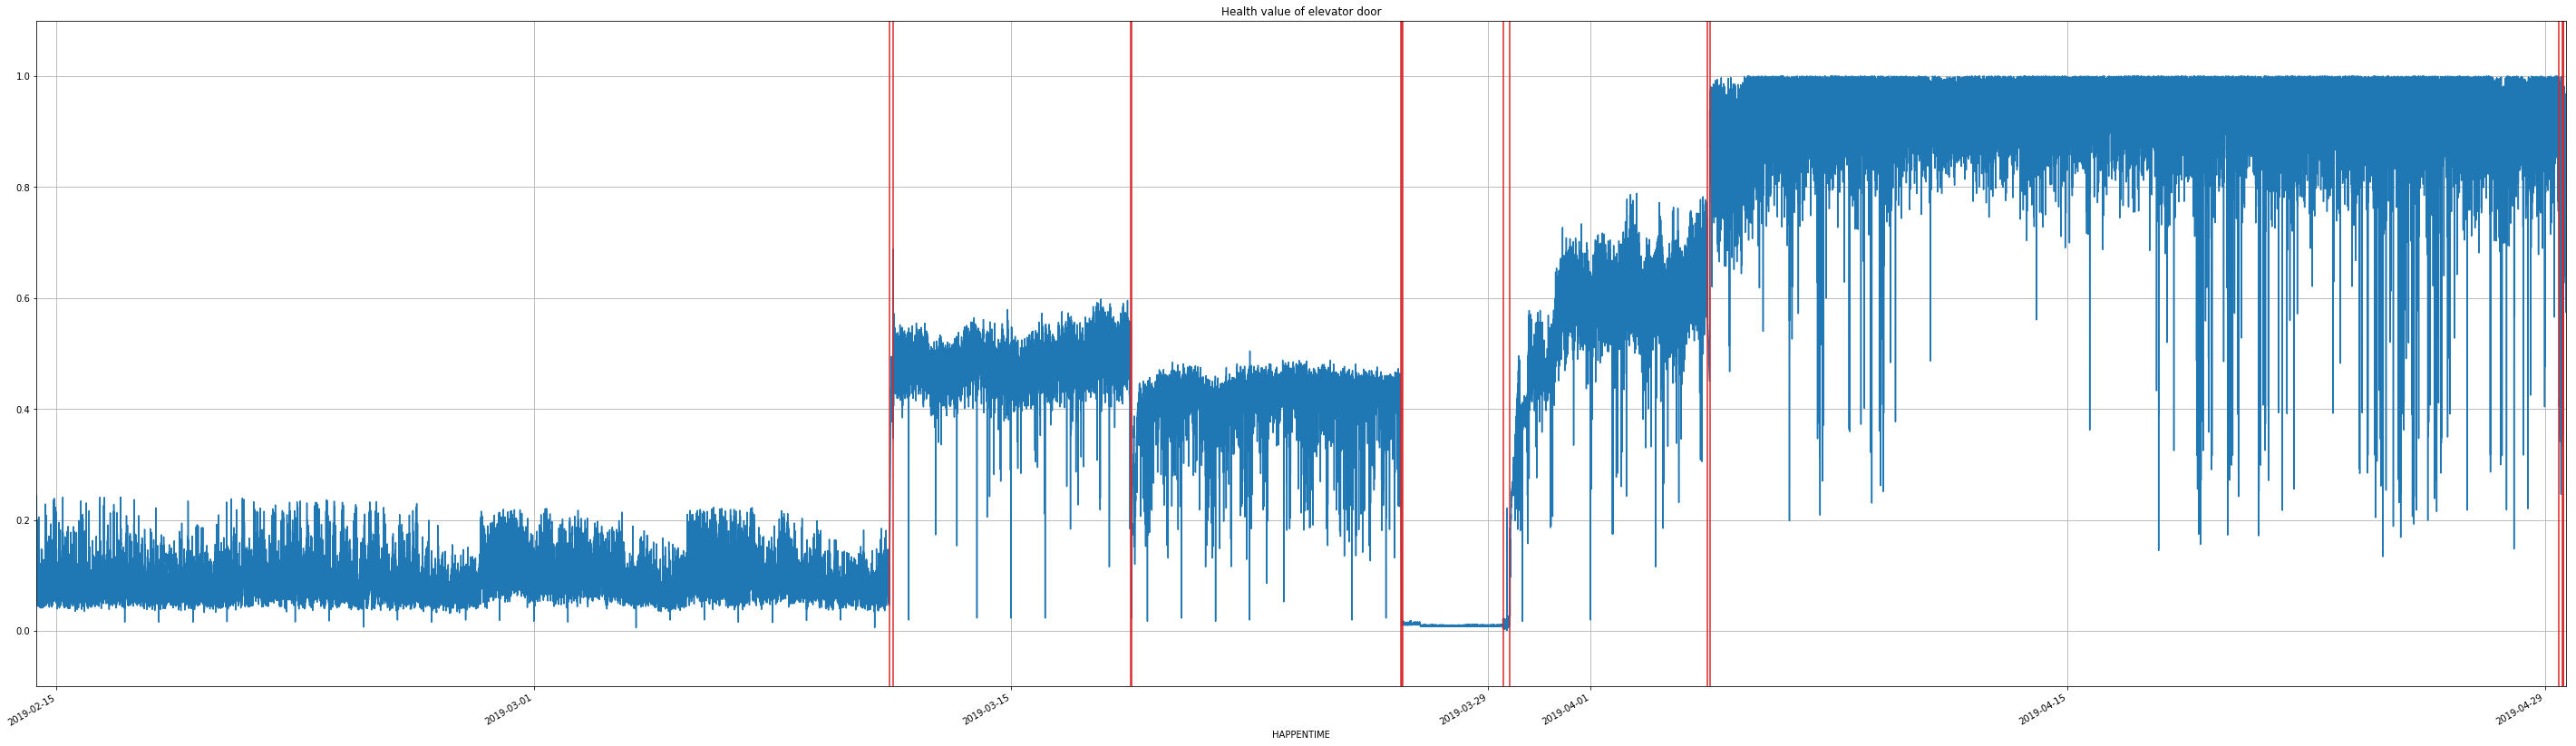

In [27]:
#画图    
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
#plt.xlim(0,14287)
plt.xlim(data_s_open.index[0],data_s_open.index[-1])
#plt.plot(data_s['cv'])
data_s_open['cv'].plot()

plt.axvline(x='2019-03-11 10:30', color='#d62728')#清除面粉+重锤，恢复正常运行状态
plt.axvline(x='2019-03-11 13:00', color='#d62728')
plt.axvline(x='2019-03-18 12:30', color='#d62728')#在导轨上加满面粉，并加入少量的水，使得导轨阻力增大
plt.axvline(x='2019-03-18 12:50', color='#d62728')
plt.axvline(x='2019-03-26 10:15', color='#d62728')#10:15 -11:00 清理摩擦故障实验导轨上的面粉
plt.axvline(x='2019-03-26 11:00', color='#d62728')#11:00-11:30  将异物固定在门导轨上，导轨关门时会与异物产生碰撞
plt.axvline(x='2019-03-26 11:30', color='#d62728')
plt.axvline(x='2019-03-29 10:20', color='#d62728')#人站在电梯门中间，模拟人为档门引起的电梯故障
plt.axvline(x='2019-03-29 15:00', color='#d62728')
plt.axvline(x='2019-04-04 10:00', color='#d62728')#清理电梯轨道面粉，恢复电梯正常工况 可以视为滑块磨损工况
plt.axvline(x='2019-04-04 12:00', color='#d62728')
plt.axvline(x='2019-04-29 10:00', color='#d62728')#再次清理电梯轨道面粉和遗留在轨道里的胶带，恢复电梯正常工况 备注	该段时间后，为滑块磨损故障
plt.axvline(x='2019-04-29 12:00', color='#d62728')
plt.axvline(x='2019-04-29 12:40', color='#d62728')#将存在一定磨损的滑块更换原先4个滑块，观察不同磨损状况的数据,该段时间后，为滑块磨损数据
plt.axvline(x='2019-04-29 13:00', color='#d62728')

plt.grid()
plt.title('Health value of elevator door')
plt.show()


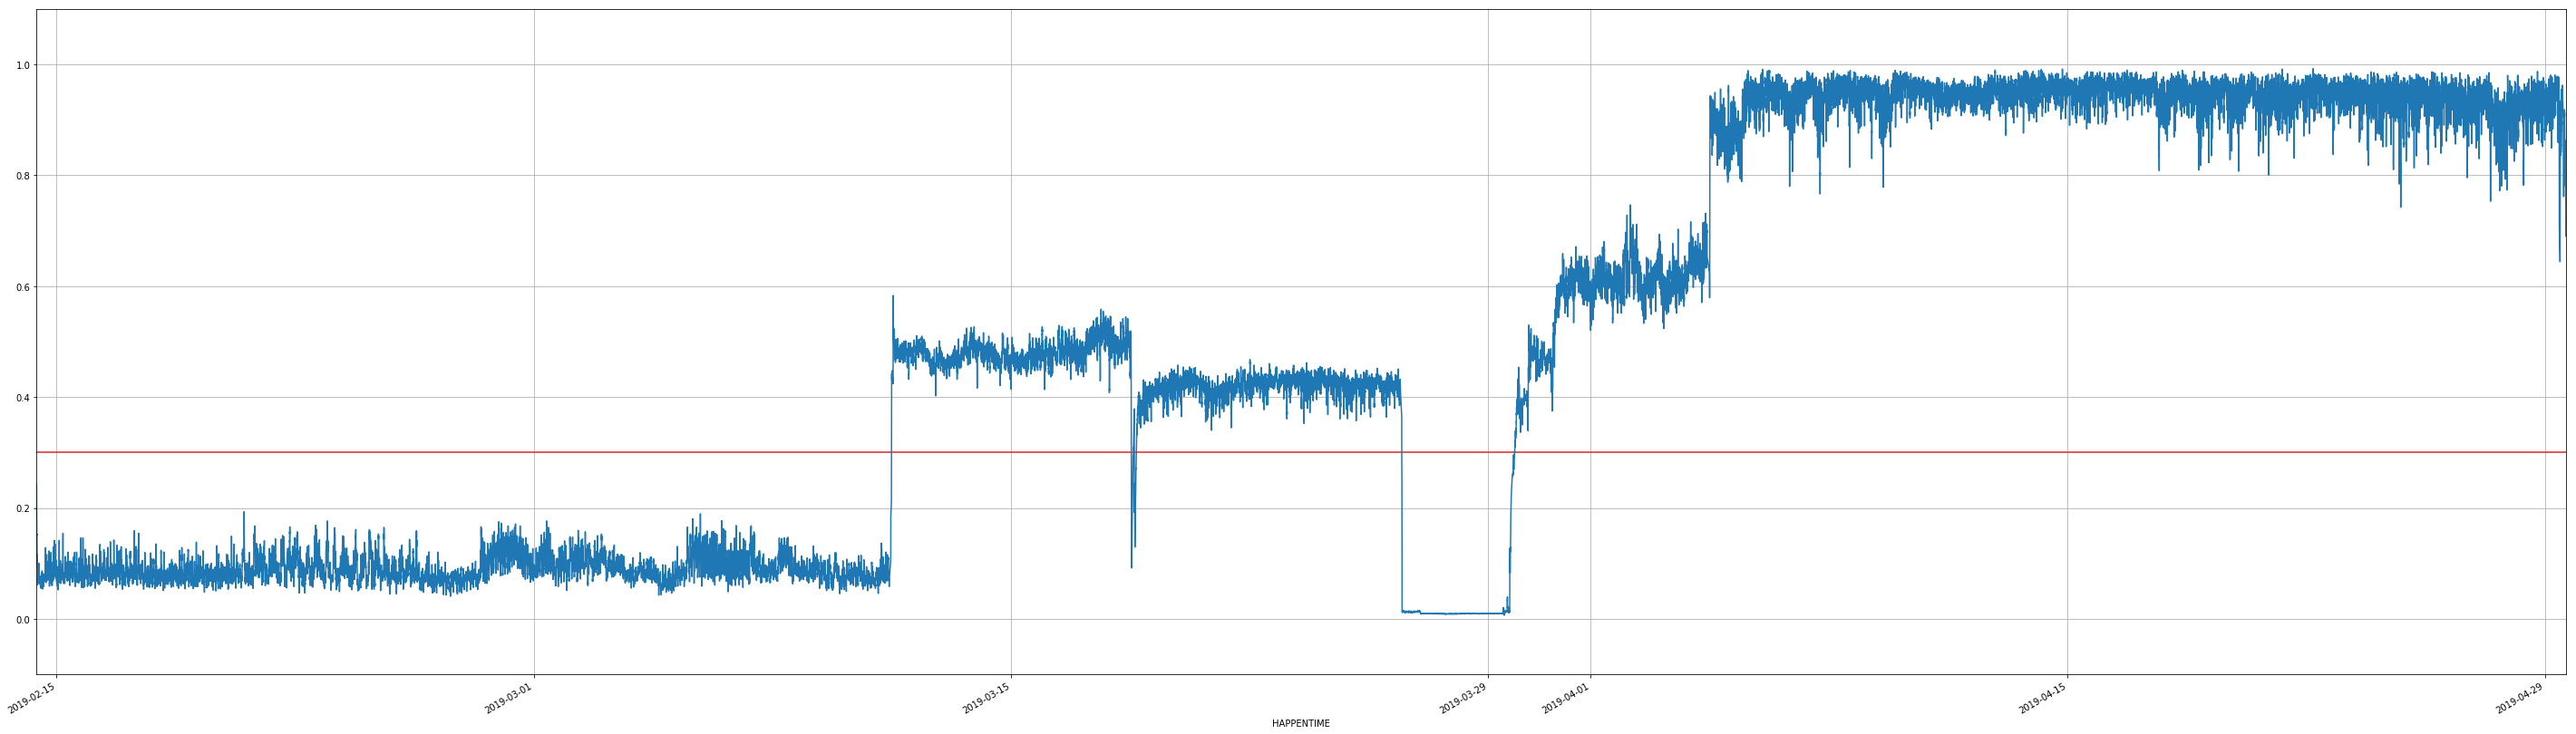

In [28]:
short_rolling_data_open=data_s_open['cv'].rolling(10,min_periods=1).mean()
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
plt.xlim(short_rolling_data_open.index[0],short_rolling_data_open.index[-1])
plt.axhline(y=0.3, color='#d62728')#画横线y=0.3
short_rolling_data_open.plot()
plt.grid()

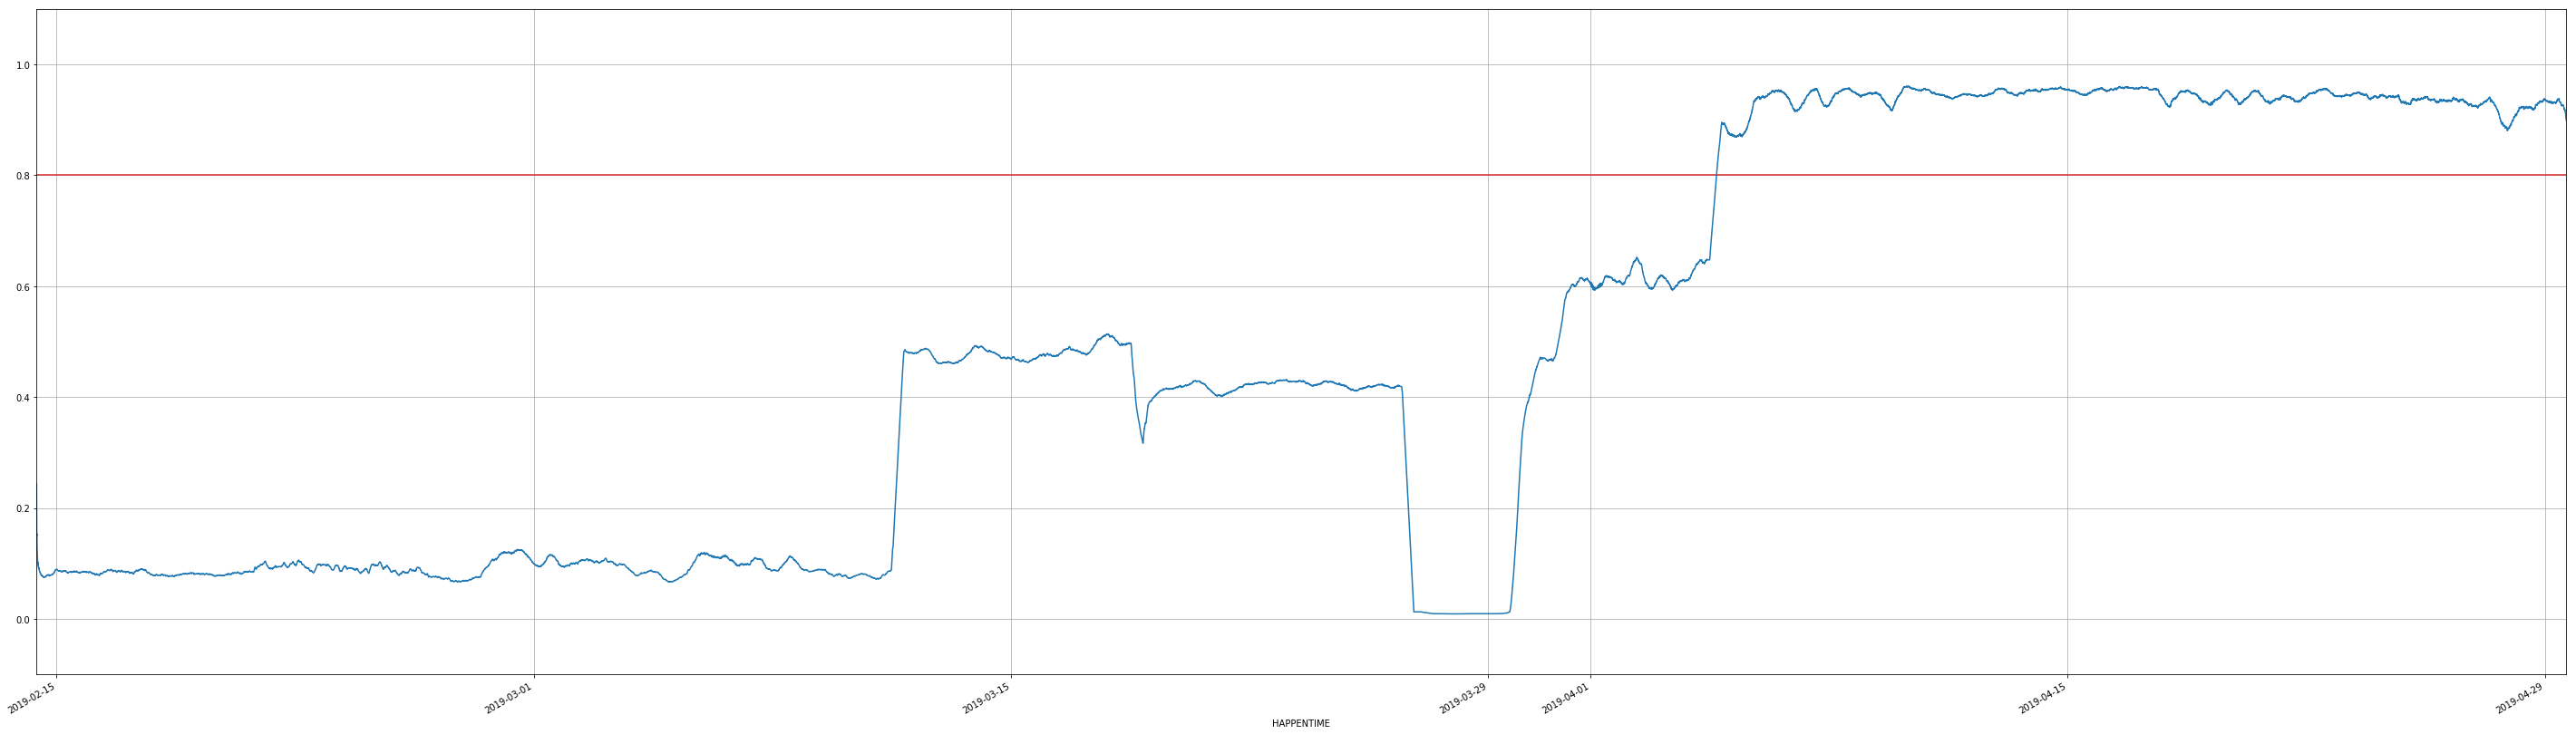

In [29]:
long_rolling_data_open=data_s_open['cv'].rolling(500,min_periods=1).mean()
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
plt.xlim(long_rolling_data_open.index[0],long_rolling_data_open.index[-1])
plt.axhline(y=0.8, color='#d62728')#画横线y=0.3

long_rolling_data_open.plot()
plt.grid()

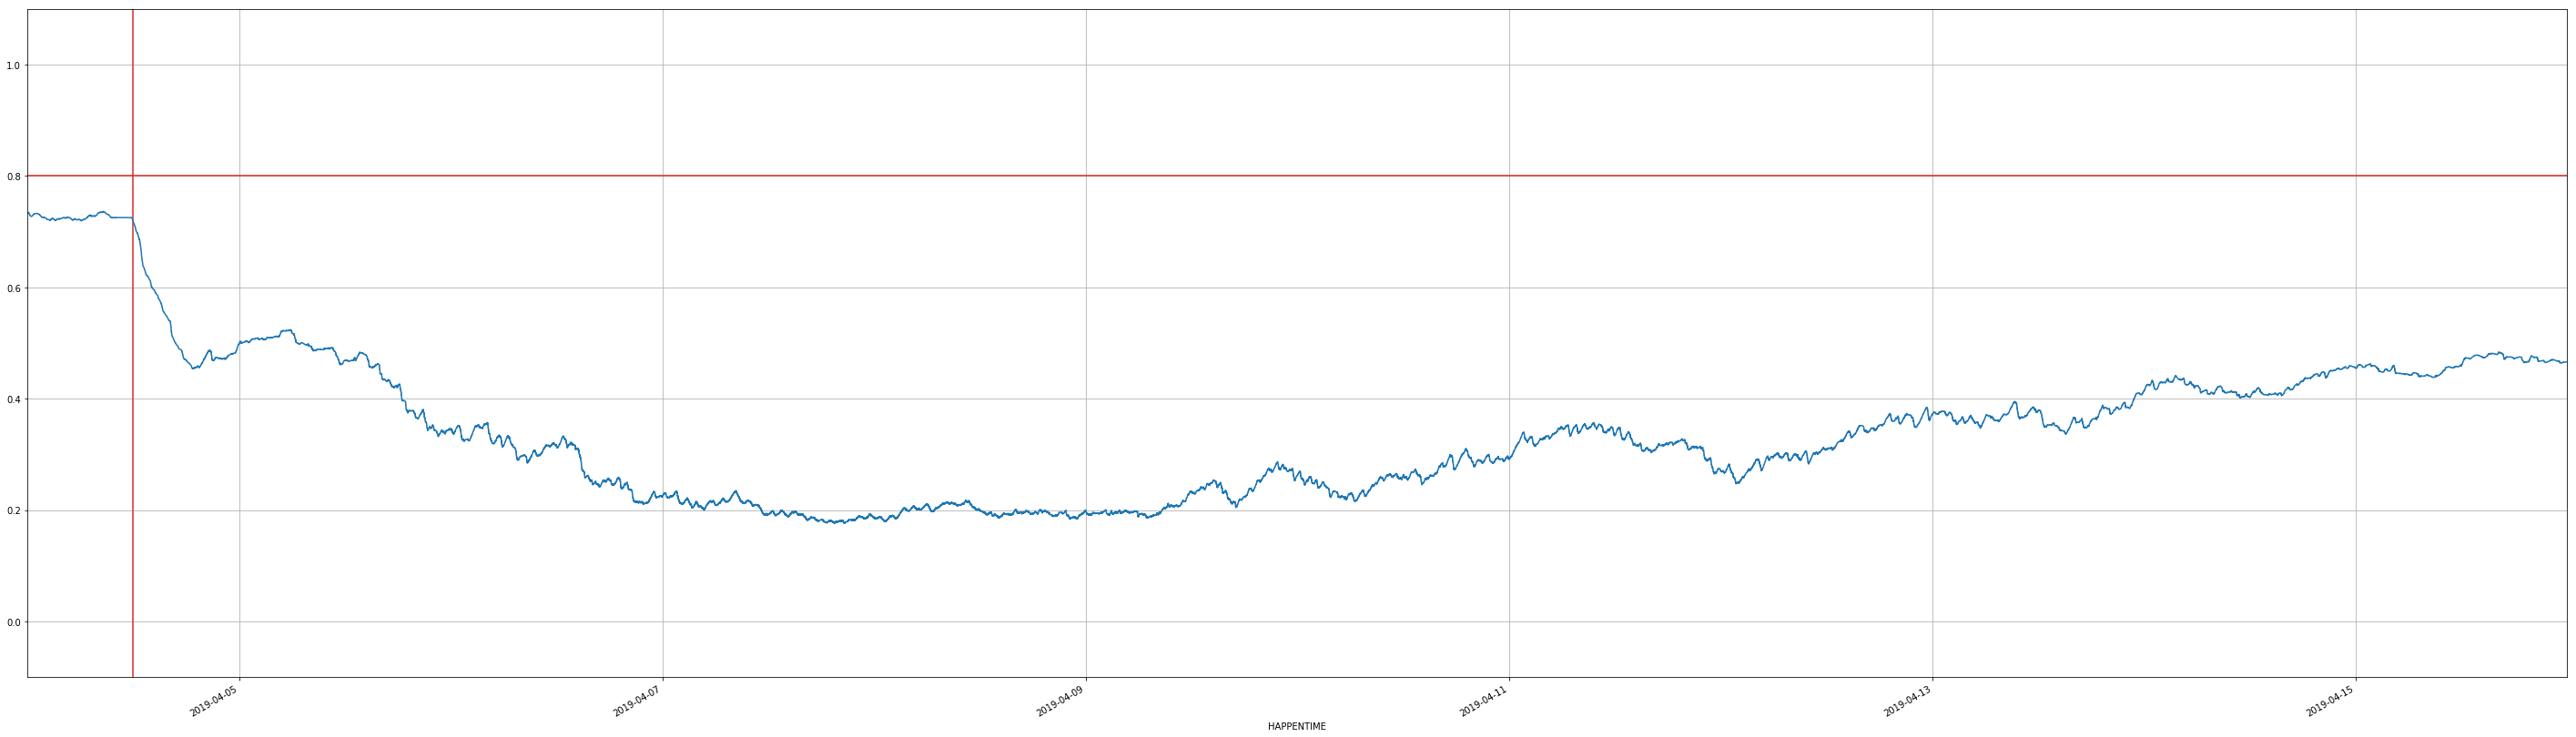

In [33]:
long_rolling_data_open_cut=long_rolling_data_open.loc['2019-04-04':'2019-04-15']
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
plt.xlim(long_rolling_data_open_cut.index[0],long_rolling_data_open_cut.index[-1])
plt.axhline(y=0.8, color='#d62728')#画横线y=0.3
plt.axvline(x='2019-04-04 12:00', color='#d62728')#清理电梯轨道面粉，恢复电梯正常工况

long_rolling_data_open_cut.plot()
plt.grid()

### 关门数据

In [30]:
#建立高斯混合模型---关门状态
if __name__ == '__main__':
    k = 1
    cv1 = np.zeros(1)
    data_so = data_st2_sd.copy()
    data_s = data_st2_sd.copy()
    
    normal_obj = joblib.load(filesave+'\onlycan_closedata_normal_obj_model0.pkl') 
    a = len(data_s)
    cv = np.zeros(a)

    
    #使用高斯混合模型进行计算
    def gmm_apply(x,k,normal_obj):
        data_l = pd.DataFrame(x)
        test_obj = gmm_clustering(k,data_l)#test_obj为训练好的gmm模型，需保存
        y = calculate_cv(normal_obj,test_obj)#y为[[cv值]]，只返回cv值
        
        return y[0][0]
    
    #计算每一行的cv值，存在data_s的cv列中         
    data_s['cv']=data_s.apply(lambda row:gmm_apply(row,k,normal_obj), axis=1)
    
    #计算cv的均值
    #cv1= data_s['cv']#cv1为Series
    #print(type(cv1))
    c = data_s['cv'].mean()
    #计算cv值小于设定阈值的个数
    count =0    
    data_s['health_label']=data_s['cv'].map(count_gmm) 
    count=data_s['health_label'].sum()   
    
    
    print(a)
    print(count)    
    print(c)
   # print(cv1.head())
    data_s_close=data_s.copy()


106286
65301
0.49354480703368914


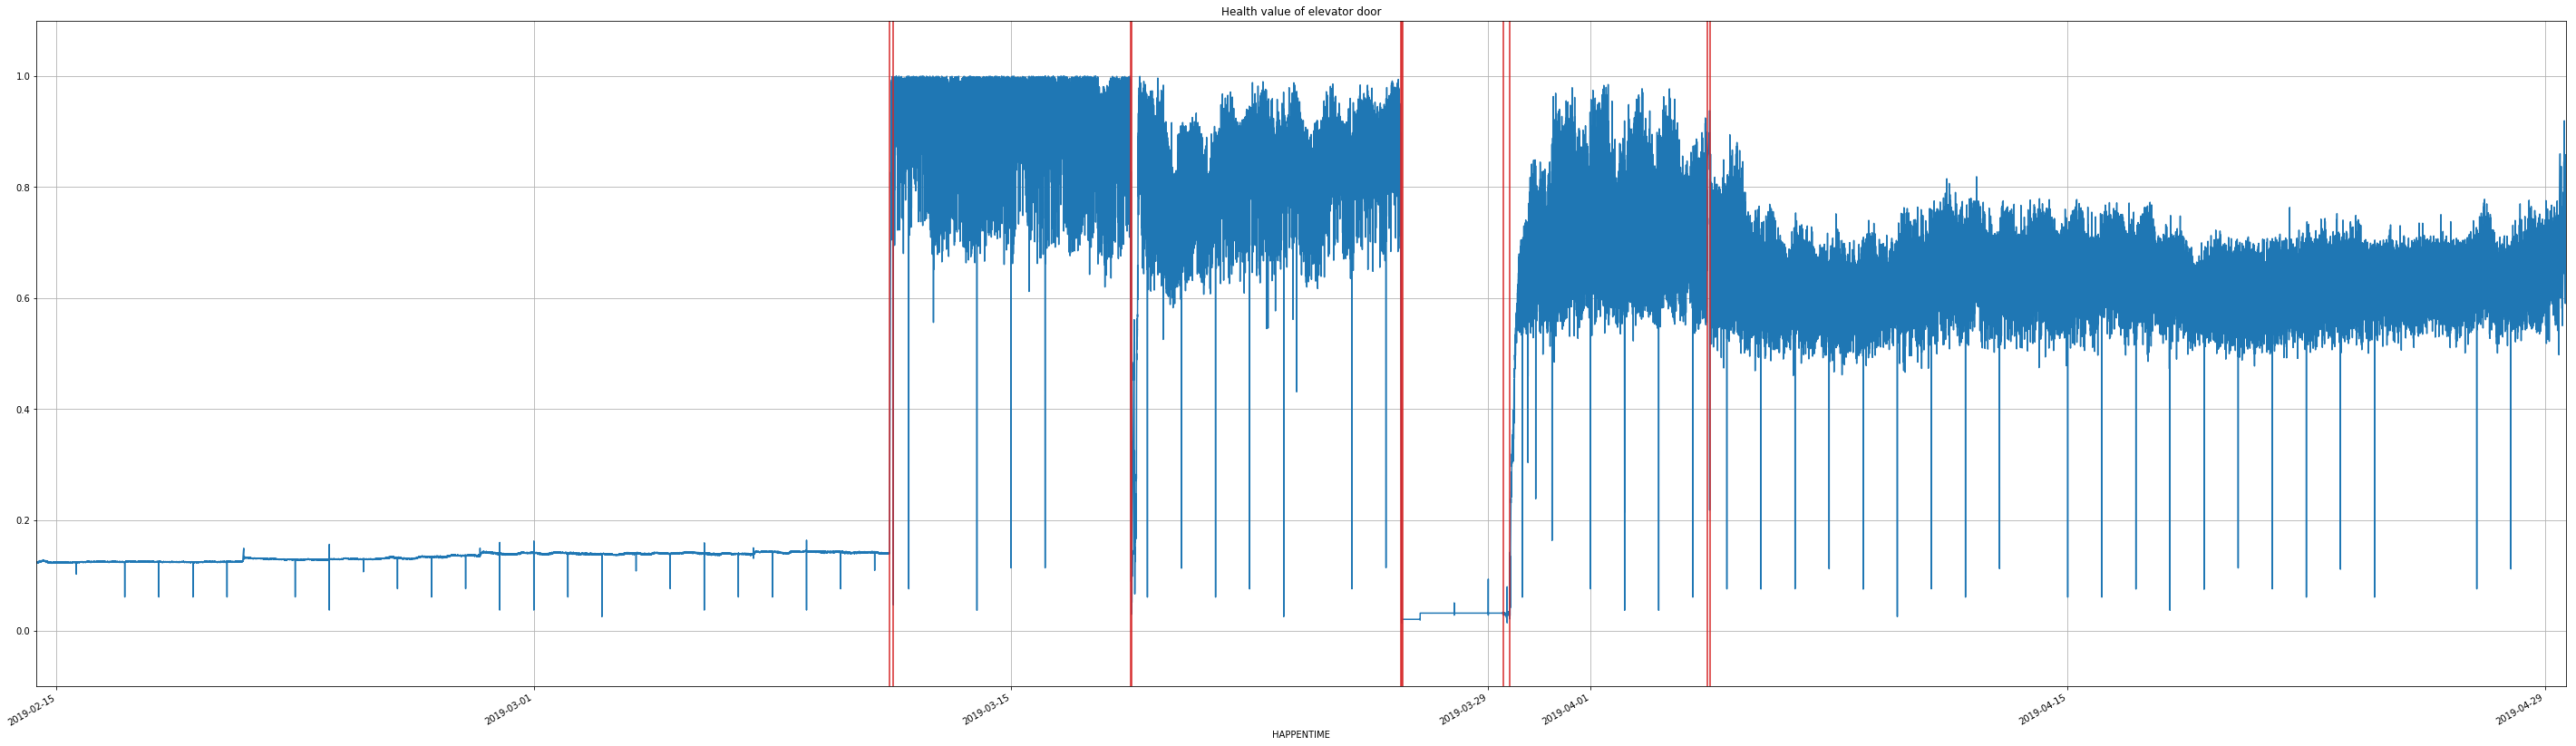

In [31]:
#画图    
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
#plt.xlim(0,14287)
plt.xlim(data_s_close.index[0],data_s_close.index[-1])
#plt.plot(data_s['cv'])
data_s_close['cv'].plot()

plt.axvline(x='2019-03-11 10:30', color='#d62728')#清除面粉+重锤，恢复正常运行状态
plt.axvline(x='2019-03-11 13:00', color='#d62728')
plt.axvline(x='2019-03-18 12:30', color='#d62728')#在导轨上加满面粉，并加入少量的水，使得导轨阻力增大
plt.axvline(x='2019-03-18 12:50', color='#d62728')
plt.axvline(x='2019-03-26 10:15', color='#d62728')#10:15 -11:00 清理摩擦故障实验导轨上的面粉
plt.axvline(x='2019-03-26 11:00', color='#d62728')#11:00-11:30  将异物固定在门导轨上，导轨关门时会与异物产生碰撞
plt.axvline(x='2019-03-26 11:30', color='#d62728')
plt.axvline(x='2019-03-29 10:20', color='#d62728')#人站在电梯门中间，模拟人为档门引起的电梯故障
plt.axvline(x='2019-03-29 15:00', color='#d62728')
plt.axvline(x='2019-04-04 10:00', color='#d62728')#清理电梯轨道面粉，恢复电梯正常工况
plt.axvline(x='2019-04-04 12:00', color='#d62728')
plt.grid()
plt.title('Health value of elevator door')
plt.show()


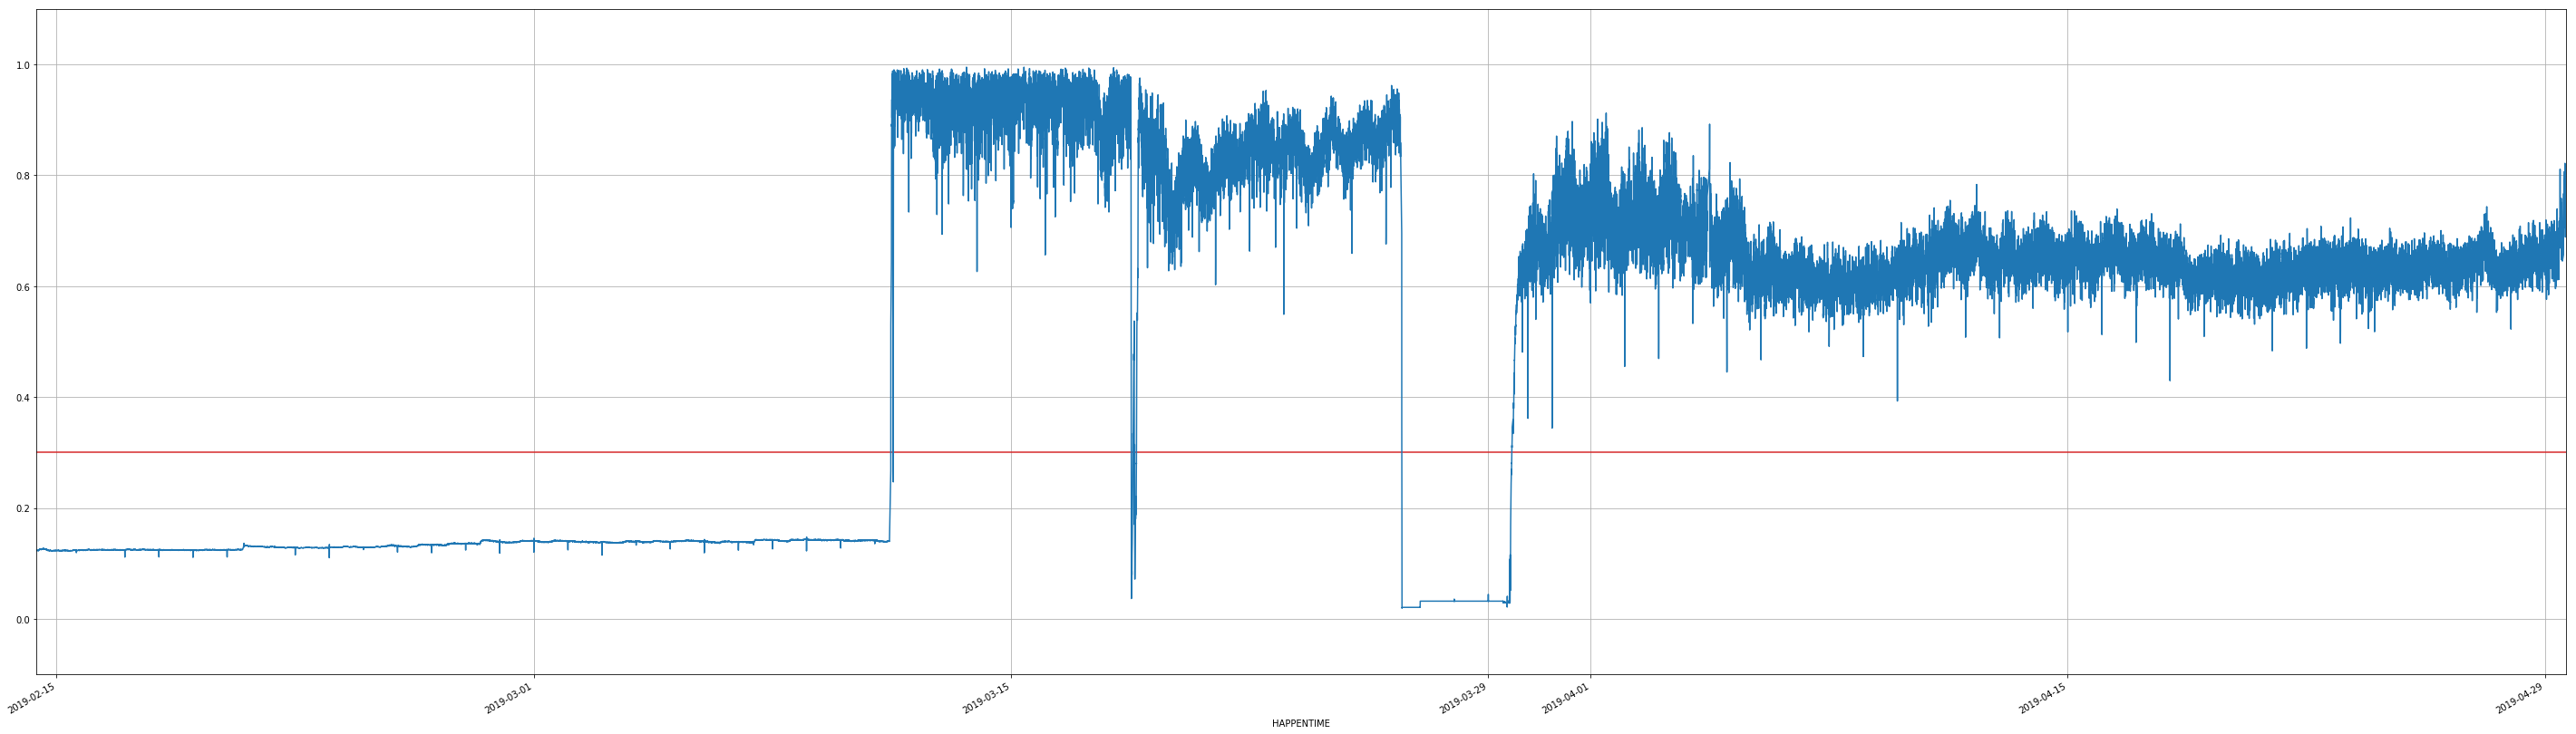

In [25]:
short_rolling_data_close=data_s_close['cv'].rolling(5,min_periods=1).mean()
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
plt.xlim(short_rolling_data_close.index[0],short_rolling_data_close.index[-1])
plt.axhline(y=0.3, color='#d62728')#画横线y=0.3
short_rolling_data_close.plot()
plt.grid()

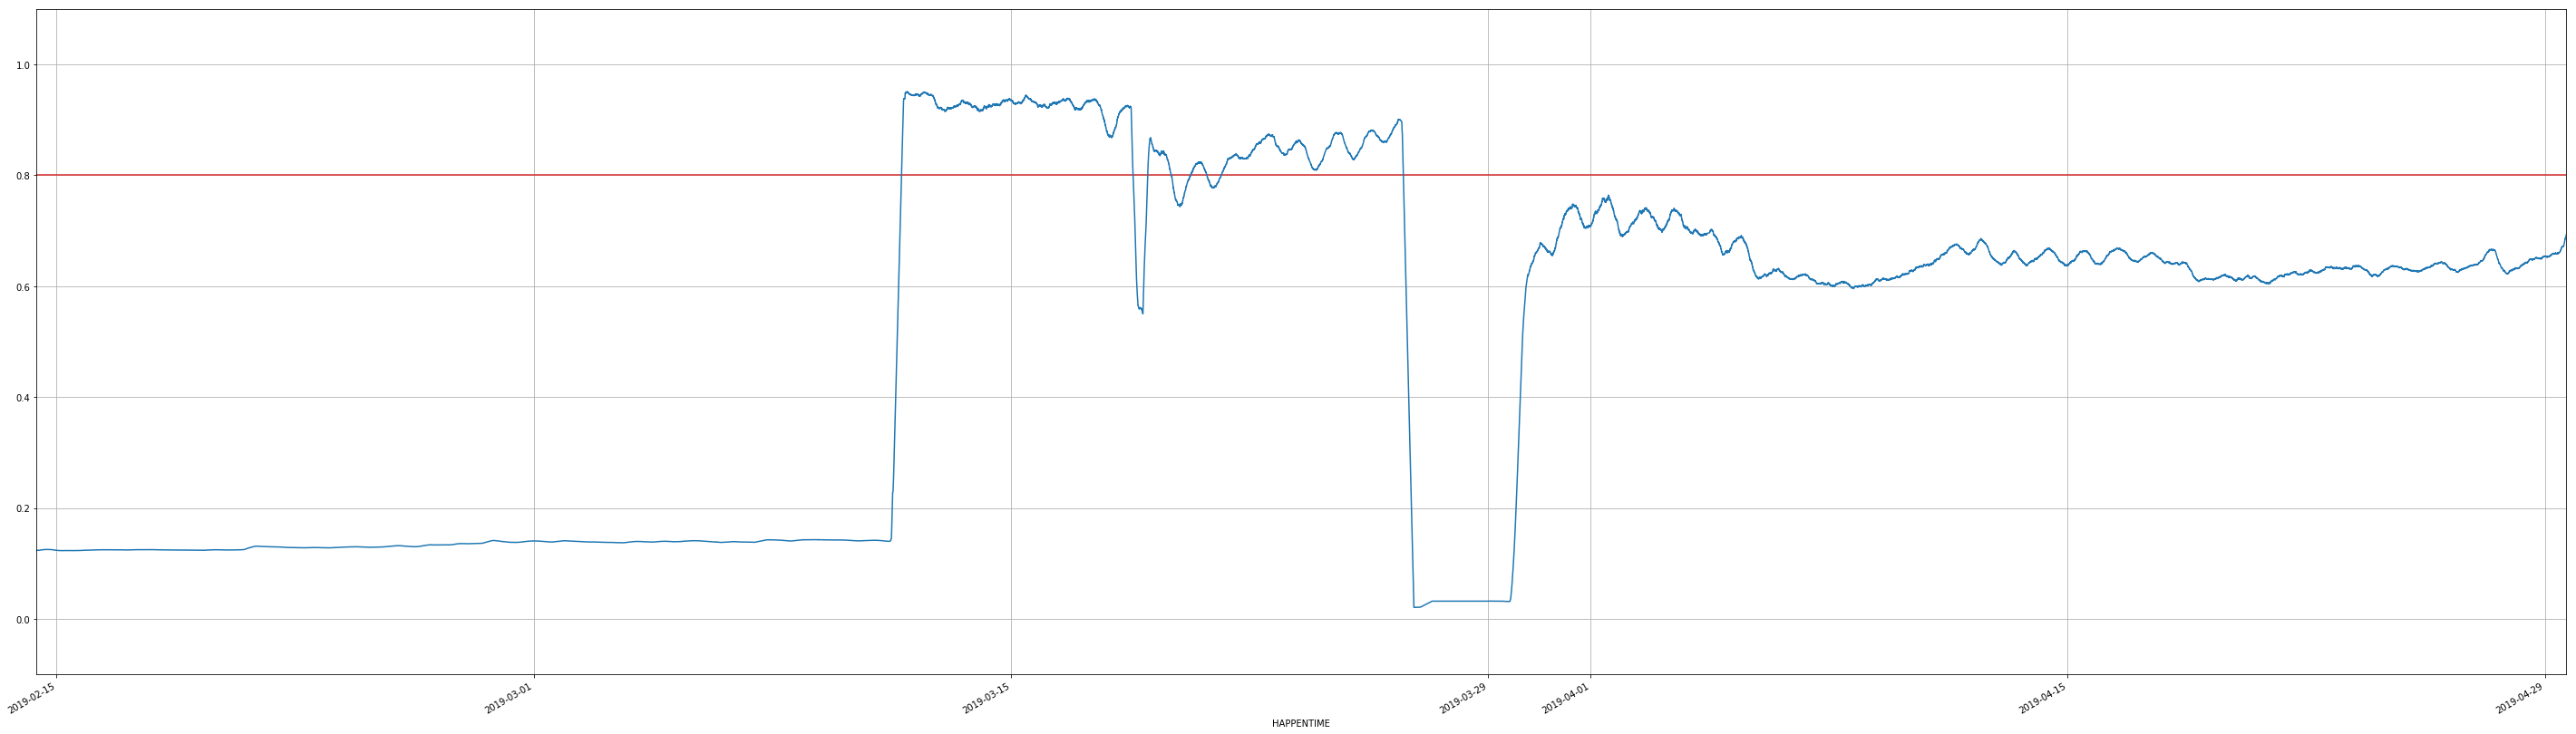

In [26]:
long_rolling_data_close=data_s_close['cv'].rolling(500,min_periods=1).mean()
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
plt.xlim(long_rolling_data_close.index[0],long_rolling_data_close.index[-1])
plt.axhline(y=0.8, color='#d62728')#画横线y=0.3
long_rolling_data_close.plot()
plt.grid()